In [ ]:
import numpy as np
from scipy.stats import poisson
from scipy.io import loadmat

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale

import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Sampling image')

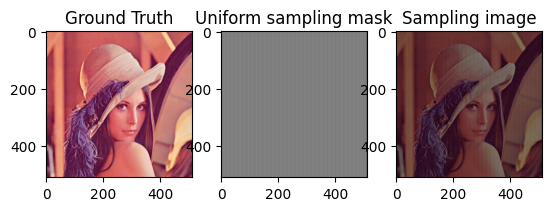

In [42]:
## 1-1. Inpainting: Uniform sampling
img = plt.imread('/content/drive/MyDrive/code_example/artifact-image/Lenna.png')

sz = img.shape
cmap = "gray" if sz[2] == 1 else None

ds_y = 1
ds_x = 2

msk = np.zeros(sz)
msk[::ds_y, ::ds_x, :] = 1

dst = img * msk

plt.subplot(131)
plt.imshow(np.squeeze(img), cmap=cmap, vmin=0, vmax=1)
plt.title("Ground Truth")

plt.subplot(132)
plt.imshow(np.squeeze(msk), cmap=cmap, vmin=0, vmax=1)
plt.title("Uniform sampling mask")

plt.subplot(133)
plt.imshow(np.squeeze(dst), cmap=cmap, vmin=0, vmax=1)
plt.title("Sampling image")

Text(0.5, 1.0, 'Sampling image')

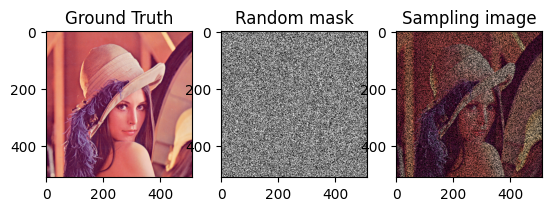

In [45]:
## 1-2. Inpainting: random sampling
rnd = np.random.rand(sz[0], sz[1], 1)
prob = 0.5
msk = (rnd < prob).astype(np.float32)
msk = np.tile(msk, (1,1,sz[2]))

dst = img * msk

plt.subplot(131)
plt.imshow(np.squeeze(img), cmap=cmap, vmin=0, vmax=1)
plt.title("Ground Truth")

plt.subplot(132)
plt.imshow(np.squeeze(msk), cmap=cmap, vmin=0, vmax=1)
plt.title("Random mask")

plt.subplot(133)
plt.imshow(np.squeeze(dst), cmap=cmap, vmin=0, vmax=1)
plt.title("Sampling image")

Text(0.5, 1.0, 'Sampling image')

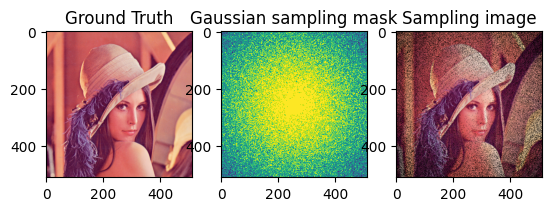

In [ ]:
## 1-3. Inpainting: Gaussian sampling
ly = np.linspace(-1, 1, sz[0])
lx = np.linspace(-1, 1, sz[1])

x, y = np.meshgrid(lx, ly)

x0 = 0
y0 = 0
sgmx = 1
sgmy = 1

a = 1

gaus = a * np.exp(-((x - x0)**2/(2*sgmx**2) + (y - y0)**2/(2*sgmy**2)))
gaus = np.tile(gaus[:, :, np.newaxis], (1,1,sz[2]))
rnd = np.random.rand(sz[0], sz[1], sz[2])
msk = (rnd < gaus).astype(np.float32)

gaus = a * np.exp(-((x - x0)**2/(2*sgmx**2) + (y - y0)**2/(2*sgmy**2)))
gaus = np.tile(gaus[:, :, np.newaxis], (1,1,1))
rnd = np.random.rand(sz[0], sz[1], 1)
msk = (rnd < gaus).astype(np.float32)

dst = img * msk

plt.subplot(131)
plt.imshow(np.squeeze(img), cmap=cmap, vmin=0, vmax=1)
plt.title("Ground Truth")

plt.subplot(132)
plt.imshow(np.squeeze(msk), cmap=cmap, vmin=0, vmax=1)
plt.title("Gaussian sampling mask")

plt.subplot(133)
plt.imshow(np.squeeze(dst), cmap=cmap, vmin=0, vmax=1)
plt.title("Sampling image")

Text(0.5, 1.0, 'Noisy image with 60.00 sigma')

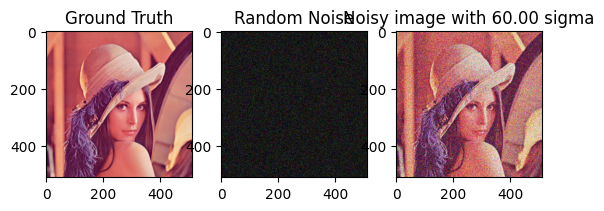

In [ ]:
## 2-1. Denoising: Random noise
sgm = 60.0

noise = sgm/255.0 * np.random.randn(sz[0], sz[1], sz[2])

dst = img + noise

plt.subplot(131)
plt.imshow(np.squeeze(img), cmap=cmap, vmin=0, vmax=1)
plt.title("Ground Truth")

plt.subplot(132)
plt.imshow(np.squeeze(noise), cmap=cmap, vmin=0, vmax=1)
plt.title("Random Noise")

plt.subplot(133)
plt.imshow(np.squeeze(dst), cmap=cmap, vmin=0, vmax=1)
plt.title(f"Noisy image with {sgm:.2f} sigma")

Text(0.5, 1.0, 'Noisy image')

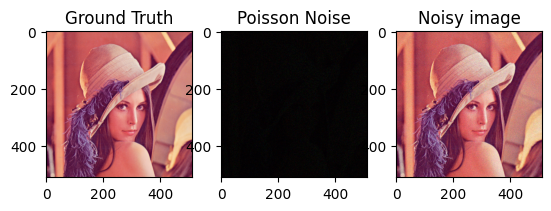

In [ ]:
## 2-2. Denoising: poisson noise (image-domain)
dst = poisson.rvs(255.0 * img) / 255.0
noise = dst - img

plt.subplot(131)
plt.imshow(np.squeeze(img), cmap=cmap, vmin=0, vmax=1)
plt.title("Ground Truth")

plt.subplot(132)
plt.imshow(np.squeeze(noise), cmap=cmap, vmin=0, vmax=1)
plt.title("Poisson Noise")

plt.subplot(133)
plt.imshow(np.squeeze(dst), cmap=cmap, vmin=0, vmax=1)
plt.title(f"Noisy image")

Text(0.5, 1.0, 'Noisy data')

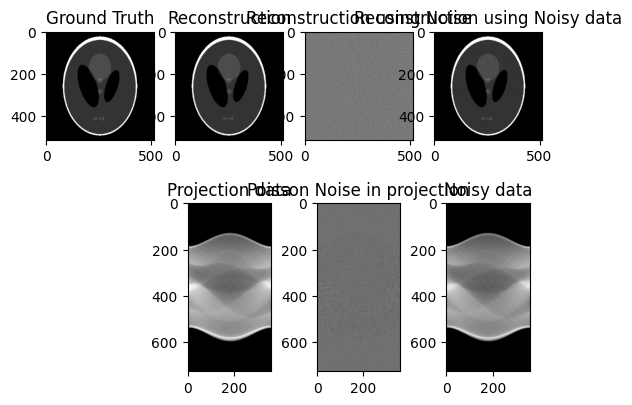

In [ ]:
## 2-3. Denoising: poisson noise (CT-domain)
# system setting
N = 512
ANG = 180
VIEW = 360
THETA = np.linspace(0, ANG, VIEW, endpoint=False)

A = lambda x: radon(x, THETA, circle=False).astype(np.float32)
AT = lambda y: iradon(y, THETA, circle=False, filter=None, output_size=N).astype(np.float32)
AINV = lambda y: iradon(y, THETA, circle=False, output_size=N).astype(np.float32)

# Low dose CT: adding poisson noise
pht = shepp_logan_phantom()
pht = 0.03 * rescale(pht, scale=512/400, order=0)

prj = A(pht)

i0 = 1e4
dst = np.exp(-prj)
dst = poisson.rvs(i0 * dst)
dst[dst < 1] = 1
dst = -np.log(dst / i0)
dst[dst < 0] = 0

noise = dst - prj

rec = AINV(prj)
rec_noise = AINV(noise)
rec_dst = AINV(dst)

plt.subplot(241)
plt.imshow(pht, cmap='gray', vmin=0, vmax=0.03)
plt.title("Ground Truth")

plt.subplot(242)
plt.imshow(rec, cmap="gray", vmin=0, vmax=0.03)
plt.title("Reconstruction")

plt.subplot(243)
plt.imshow(rec_noise, cmap="gray")
plt.title("Reconstruction using Noise")

plt.subplot(244)
plt.imshow(rec_dst, cmap="gray", vmin=0, vmax=0.03)
plt.title("Reconstruction using Noisy data")

plt.subplot(246)
plt.imshow(prj, cmap="gray")
plt.title("Projection data")

plt.subplot(247)
plt.imshow(noise, cmap="gray")
plt.title("Poisson Noise in projection")

plt.subplot(248)
plt.imshow(dst, cmap="gray")
plt.title("Noisy data")

Text(0.5, 1.0, 'Upscaled image')

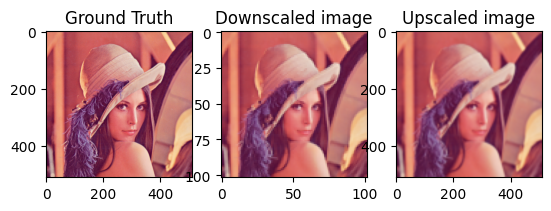

In [ ]:
## 3. Super-resolution
"""
----------------------
order options
----------------------
0: Nearest-neighbor
1: Bi-linear (default)
2: Bi-quadratic
3: Bi-cubic
4: Bi-quartic
5: Bi-quintic
"""

dw = 1/5.0
order = 1

dst_dw = rescale(img, scale=(dw, dw, 1), order=order)
dst_up = rescale(dst_dw, scale=(1/dw, 1/dw, 1), order=order)

plt.subplot(131)
plt.imshow(np.squeeze(img), cmap=cmap, vmin=0, vmax=1)
plt.title("Ground Truth")

plt.subplot(132)
plt.imshow(np.squeeze(dst_dw), cmap=cmap, vmin=0, vmax=1)
plt.title("Downscaled image")

plt.subplot(133)
plt.imshow(np.squeeze(dst_up), cmap=cmap, vmin=0, vmax=1)
plt.title(f"Upscaled image")